# Advanced Profit & Loss Forecasting with LSTM and Monte Carlo Simulation

This notebook demonstrates a complete workflow for forecasting revenue (from Profit & Loss data) using an LSTM network. The process includes:

- **Data Ingestion & Preprocessing:** Load (or generate) synthetic monthly Profit & Loss data.
- **Feature Engineering & Visualization:** Compute Profit and visualize historical trends.
- **LSTM Forecasting:** Prepare data using a sliding window, train an LSTM model, and forecast future revenue.
- **Monte Carlo Simulation:** Estimate prediction uncertainty by simulating forecast outcomes.
- **Visualization:** Plot historical data, forecasts, prediction intervals, and simulation histograms using Matplotlib.


In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from datetime import datetime, timedelta

# TensorFlow and Keras for building the LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Sklearn for scaling and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## Data Ingestion

We will load historical Profit & Loss data from a CSV file named `historical_pl.csv`.  
If the file does not exist, synthetic data will be generated for monthly records from January 2018 to December 2023, including:
- **Date**
- **Revenue**
- **Expenses**


In [2]:
# Data Ingestion
data_file = 'historical_pl.csv'
if os.path.exists(data_file):
    df = pd.read_csv(data_file, parse_dates=['Date'])
else:
    # Generate synthetic monthly data from Jan 2018 to Dec 2023
    dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='M')
    revenue = np.random.normal(loc=100000, scale=5000, size=len(dates))
    expenses = revenue * np.random.uniform(0.6, 0.9, size=len(dates))
    df = pd.DataFrame({'Date': dates, 'Revenue': revenue, 'Expenses': expenses})
    df.to_csv(data_file, index=False)

# Show the first few rows of the data
print("Historical P&L Data (Head):")
display(df.head())


Historical P&L Data (Head):


,Date,Revenue,Expenses
0,2018-01-31,102483.570765,85193.583322
1,2018-02-28,99308.678494,74296.663533
2,2018-03-31,103238.442691,78132.902589
3,2018-04-30,107615.149282,78372.056724
4,2018-05-31,98829.233126,60051.185717


## Data Preprocessing & Feature Engineering

Steps:
- Sort the data by date.
- Forward-fill any missing values.
- Compute **Profit** as Revenue minus Expenses.
- (Optional) You can add additional time-based features if desired.


In [3]:
# Data Preprocessing
df.sort_values('Date', inplace=True)
df.fillna(method='ffill', inplace=True)

# Compute Profit
df['Profit'] = df['Revenue'] - df['Expenses']

# (Optional) You can add additional time-based features if needed.
# For now, we focus on Revenue forecasting.

print("Preprocessed Data:")
display(df.head())


Preprocessed Data:


,Date,Revenue,Expenses,Profit
0,2018-01-31,102483.570765,85193.583322,17289.987443
1,2018-02-28,99308.678494,74296.663533,25012.014961
2,2018-03-31,103238.442691,78132.902589,25105.540102
3,2018-04-30,107615.149282,78372.056724,29243.092558
4,2018-05-31,98829.233126,60051.185717,38778.047410


## Visualization of Historical Data

We plot historical Revenue and Profit trends using Matplotlib.


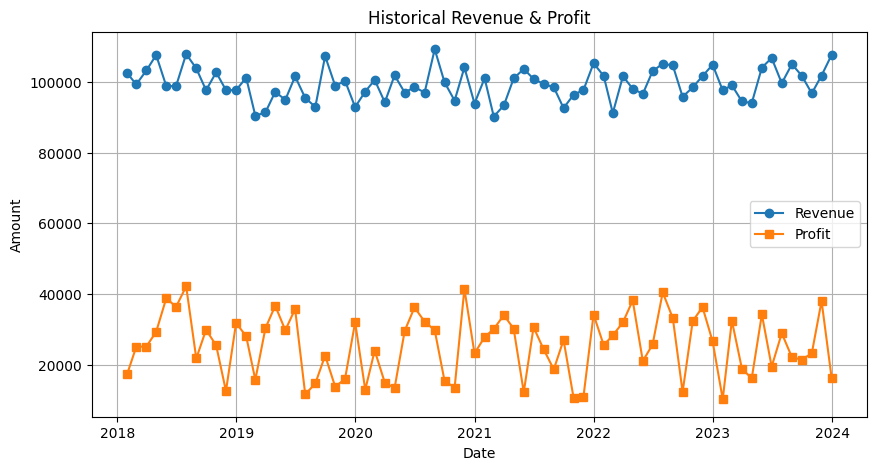

In [4]:
# Visualization of Historical Data
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Revenue'], label='Revenue', marker='o')
plt.plot(df['Date'], df['Profit'], label='Profit', marker='s')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Historical Revenue & Profit')
plt.legend()
plt.grid(True)
plt.show()


## Data Preparation for LSTM Forecasting

For LSTM, we transform the time series into a supervised learning problem by creating sequences using a sliding window approach.  
We will:
- Scale the Revenue data using MinMaxScaler.
- Create sequences of `look_back` months to predict the next month.


In [5]:
# Define a function to create sequences from the time series
def create_dataset(series, look_back=12):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)

# Extract Revenue values and scale them between 0 and 1
revenue_values = df['Revenue'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
revenue_scaled = scaler.fit_transform(revenue_values)

# Define look_back period (e.g., use past 12 months to predict next month)
look_back = 12
X, y = create_dataset(revenue_scaled, look_back)

# Reshape X to be [samples, time steps, features] for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 48, Testing samples: 12


## LSTM Model: Building and Training

We build an LSTM model with:
- Two LSTM layers (with dropout for regularization)
- A Dense output layer  
We then train the model on the training data and validate it on the test set.


In [6]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.1846 - val_loss: 0.1142
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0733 - val_loss: 0.0627
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1067 - val_loss: 0.0544
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0787 - val_loss: 0.0669
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0679 - val_loss: 0.0649
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0705 - val_loss: 0.0576
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0751 - val_loss: 0.0561
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0733 - val_loss: 0.0587
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0709 - val_loss: 0.0610
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0652 - val_loss: 0.0588
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0696 - val_loss: 0.0580
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0676 - val_loss: 0.0598
E

## Training Loss Visualization

We plot the training and validation loss curves to observe the model's convergence.


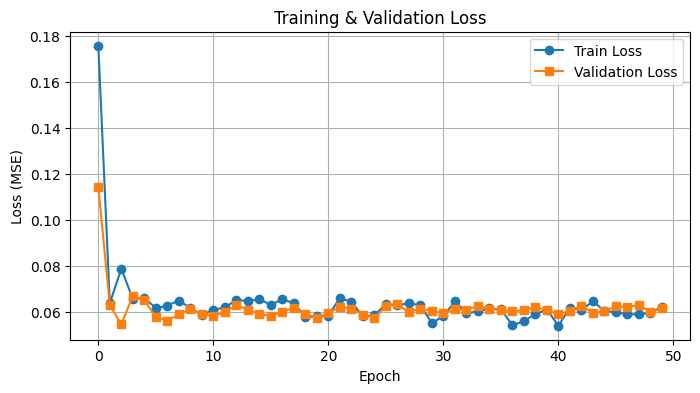

In [7]:
# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Forecasting Future Revenue with LSTM

Using an iterative approach, we forecast the next 12 months.  
Starting from the last observed sequence, we predict one month at a time and update the sequence with the predicted value.


In [8]:
# Forecasting Future Revenue using LSTM
forecast_periods = 12  # Number of months to forecast

# Get the last 'look_back' values from the scaled data to start forecasting
last_sequence = revenue_scaled[-look_back:].copy()
forecast_lstm = []

for i in range(forecast_periods):
    # Reshape to match LSTM input dimensions: [1, look_back, 1]
    input_seq = np.reshape(last_sequence, (1, look_back, 1))
    pred_scaled = model.predict(input_seq)
    forecast_lstm.append(pred_scaled[0, 0])
    # Append the prediction and slide the window: remove the first element
    last_sequence = np.append(last_sequence, pred_scaled[0, 0])
    last_sequence = last_sequence[1:]

# Inverse transform the forecast to original scale
forecast_lstm = np.array(forecast_lstm)
forecast_lstm_unscaled = scaler.inverse_transform(forecast_lstm.reshape(-1, 1)).flatten()

# Create dates for the forecast period
last_date = df['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=forecast_periods, freq='M')

# Combine forecast into a DataFrame
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast_Revenue': forecast_lstm_unscaled})
print("LSTM Forecast for Future Revenue:")
display(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM Forecast for Future Revenue:


,Date,Forecast_Revenue
0,2024-01-31,99119.085938
1,2024-02-29,99170.382812
2,2024-03-31,99184.320312
3,2024-04-30,99213.507812
4,2024-05-31,99227.578125
5,2024-06-30,99168.125000
6,2024-07-31,99091.000000
7,2024-08-31,99065.328125
8,2024-09-30,99002.562500
9,2024-10-31,98966.257812


## Monte Carlo Simulation for Prediction Uncertainty

Since LSTM does not inherently provide prediction intervals, we:
1. Compute residual errors on the test set.
2. Estimate the standard deviation of these residuals.
3. For each forecasted value (here, we illustrate for the first forecast month),
   we simulate many outcomes by adding normally distributed noise.


In [9]:
# Predict on test data to calculate residuals
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
residuals = y_test_actual.flatten() - y_test_pred.flatten()
residual_std = np.std(residuals)
print(f"Residual Standard Deviation: {residual_std:.2f}")

# For the first forecasted month, perform Monte Carlo simulation
num_simulations = 1000
first_forecast_value = forecast_df.iloc[0]['Forecast_Revenue']
simulations = np.random.normal(loc=first_forecast_value, scale=residual_std, size=num_simulations)
lower_sim = np.percentile(simulations, 5)
upper_sim = np.percentile(simulations, 95)

print("Monte Carlo Simulation for First Forecast Month:")
print(f"Simulated 5th Percentile: {lower_sim:.2f}, 95th Percentile: {upper_sim:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Residual Standard Deviation: 4404.01
Monte Carlo Simulation for First Forecast Month:
Simulated 5th Percentile: 92398.76, 95th Percentile: 106767.88


## Final Forecast Visualization

We will now plot:
- Historical Revenue data.
- LSTM Forecasted Revenue for the next 12 months.
- A shaded area representing the Monte Carlo simulation-based prediction interval for the first forecasted month.


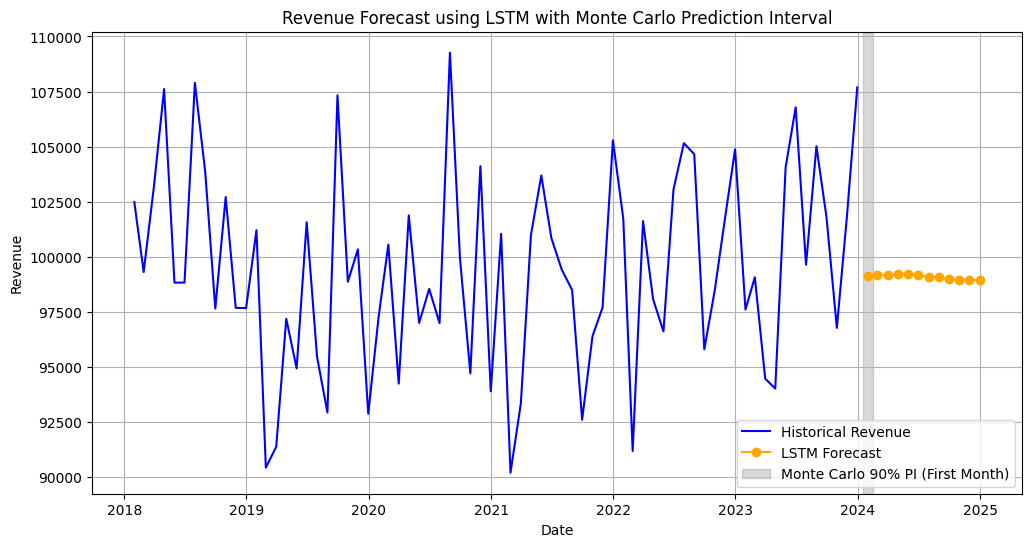

In [10]:
# Plot historical revenue and forecasted revenue
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Revenue'], label='Historical Revenue', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast_Revenue'],
         label='LSTM Forecast', marker='o', color='orange')

# For illustration, show prediction interval for the first forecast month as a vertical band
plt.axvspan(forecast_df['Date'].iloc[0] - timedelta(days=15),
            forecast_df['Date'].iloc[0] + timedelta(days=15),
            color='gray', alpha=0.3, label='Monte Carlo 90% PI (First Month)')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue Forecast using LSTM with Monte Carlo Prediction Interval')
plt.legend()
plt.grid(True)
plt.show()


## Monte Carlo Simulation Histogram

We display a histogram of the simulated outcomes for the first forecasted month to illustrate the distribution and uncertainty.


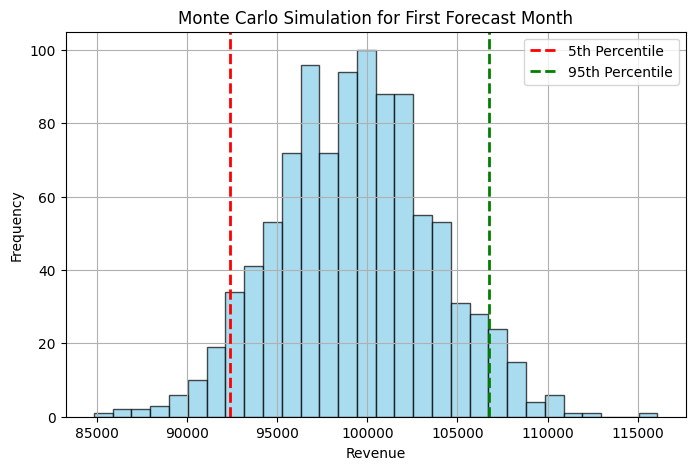

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(simulations, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(lower_sim, color='red', linestyle='dashed', linewidth=2, label='5th Percentile')
plt.axvline(upper_sim, color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation for First Forecast Month')
plt.legend()
plt.grid(True)
plt.show()


## Summary and Conclusion

- **Data Ingestion & Preprocessing:** We loaded (or generated) monthly P&L data, computed Profit, and visualized historical trends.
- **LSTM Forecasting:** Data was prepared using a sliding window, and an LSTM model was trained to forecast future revenue.
- **Monte Carlo Simulation:** We estimated prediction uncertainty by simulating forecast outcomes based on test-set residuals.
- **Visualization:** Matplotlib was used to plot historical data, forecast results, and simulation histograms.

This notebook provides an end-to-end demonstration of advanced forecasting using LSTM and uncertainty quantification through Monte Carlo simulation.
